# What is Modem?

I bet that you've heard the word modem before.  Isn't it that box that gives me internet access? But do you know what it is?  A modem is shorthand for *modulator-demodulation*.

Modulation is all about transmitting information through a medium, or *channel*, in some specific way.  Information is
conveyed by modifying a template signal in a prescribed way that is understood by a receiver.  Here's our template signal:

\begin{equation}
    x(t) = A (t) \cos \left(\omega (t) t + \phi (t) \right). 
\end{equation}

Information is injected into this template by varying the amplitude $A(t)$, angular frequency $\omega (t)$, and or phase $\phi(t)$.  In this post, we will introduce a family of modulation techniques centered on varying the phase, called *Phase Shift Keying* (PSK).


## PSK Modulation

The standard derivation of PSK modulation follows from standard trigonometric identities:  

\begin{align}
    x_{p}(t) &= \cos (2\pi f_{c} t + \phi(t)) \\
             &= \cos (\phi(t)) \cos (2\pi f_{c} t) - \sin (\phi(t)) \sin (2\pi f_{c} t) \\
             &= I(t) \cos (2\pi f_{c} t) - Q(t) \sin (2\pi f_{c} t) 
\end{align}

The $I(t)= \cos (\phi(t))$ and $Q(t)=\sin (\phi(t))$ are the inphase and quadrature waveforms.  If you take a step back, you can see an interesting phenomena: phase modulation is equivalent to amplitude modulation.

It turns out to be very convenient to represent this last expression in terms of complex waveforms:

\begin{align}
    x_{c} (t) = \operatorname{Re} (z_{b} (t) \exp(2\pi i f_{c} t)) 
\end{align}

where $z_{b} (t)$ is the complex baseband waveform

\begin{equation}
    z_{b} (t) = I(t) + i Q(t)=\exp(i\phi(t)).
\end{equation}

The complex formulation is great because it seperates the baseband waveform, $z_{b}$, from the potentially much higher frequency carrier.  

## PSK Demodulation


### Bits and Symbols

The most fundamental unit of information is digital communication is the bit.  Different modulation schemes package up groups of bits into larger pieces of data called symbols.  Below are constellation diagrams for two very common and effective PSK schemes: BPSK and QPSK.  Constellation diagrams provide a compact way of describing the correspondance between bits, symbols, phases, and amplitude levels.    

![title](images/constellation.png)

The QPSK constellation is a little more interesting so I'll work on describing it in a little more detail.  Let's provide some context.  Suppose you want to transmit the bit sequence 

\begin{equation}
    b = \left[ 0,1,1,0,1,0,0,1,0,1,0,0,1,1,1,0,1,0\right]
\end{equation}

through some unspecified channel.  In QPSK, each symbol is made from two consecutive bits.  Our bit sequence is therefore transformed into the following sequence of symbols:

\begin{equation}
    s = \left[ 01, 10, 10, 01, 01, 00, 11, 10, 10 \right].
\end{equation}

So far so good.  Now we need to consult the constellation diagram.  If we want to transmit the symbol $01$, then we should choose 

\begin{equation}
    \phi(t) = \frac{3\pi}{4}, \quad 0\le t \le T
\end{equation}

which means that the baseband waveform for this time segment should be

\begin{equation}
    z_{b} (t) = I(t) + i Q(t) 
              = \cos(\phi(t)) + \sin(\phi(t)) 
              = -\frac{\sqrt{2}}{2} + i\frac{\sqrt{2}}{2}.
\end{equation}

The time variable $T$ represents the duration of each symbol.  Its reciprocal is commonly called the symbol rate, 
or baud rate.  Another parameter we need to start thinking about is the number of samples per symbol.  You get this by dividing the sample rate by the symbol rate.


## Distributed Systems

We're eventually going to start implementing some of these ideas in Python.  But first we need to think about the overall system design.  I naturally default to object oriented principles, that's probably not the right approach here.  I think it's more appropriate to view the system in terms of dataflow.  Before we get to an implementation of these ideas, let's explore tools from the Python language we can use to realize a true dataflow.


![title](images/stream_qpsk.png)

### Coroutines

I'm not going to formally define coroutines here.  There are plenty of resources out there for that.  What I will say is that they are a very convenient tool for building stream-processing systems.  Stream processing is probably another thing that requires a formal definition, but I'm not going to go there.  I'm going to call something a stream processor, or transducer, when it converts one stream into another.  And a stream is just what it sounds like; a possibly infinite sequence of data.  Since we can't store an infinite sequence of anything in memory, a stream processor will operate on a per-element basis.

For technical reasons, it's really handy to define a decorator for dealing with coroutines in Python.  Otherwise, we would need to *prime* it manually.  Here's a decorator that does the initialization magic.  The `func` function passed to `coroutine` is the actual coroutine.  

In [83]:
def coroutine(func):
    def wrapper(*args,**kwargs):
        f = func(*args,**kwargs)
        f.send(None)
        return f
    return wrapper

Here's an example of a very simple stream processor you would find in any book on digital electronics, a D flip-flop.  I think it's fair to say that flip-flops are amongst the most fundamental and important components in FPGA design.  And they can get quite a bit more compplicated than this one.  A D flip flop can be used to store a bit for safe keeping, or until directed otherwise.  You can also add some delay to a bitstream by chaining a bunch of D flip flops together.

In [84]:
@coroutine
def flip_flop(outport):
    reg = 0
    while True:
        new = (yield)
        outport.send(reg)
        reg = new

This is a pretty straight forward function.  The `reg` is a 1 bit register that stores incoming data.  After this, the function runs forever, but pauses its execution at the `(yield)` statement until it receives data from another process.  This received data is bound to the `new` variable and the value stored in `reg` is sent to the coroutine indicated by `outport`.  Finally the freshly received data is bound to `reg`.  

Whew!  That was a mouthful.  Let's test it out.  First, we need another coroutine that gets the output from the flip flop and prints it to the screen.

In [85]:
@coroutine
def view():
    while True:
        x = (yield)
        print(x)

Now we need to create each of these two coroutines and pump some bits through.  Notice that the output is indeed delayed by a single bit.

In [112]:
v = view()
d = flip_flop(v)

for b in [1,0,1,0,1,0,0,1]:
    d.send(b)

0
1
0
1
0
1
0
0


That's progress.  Just for fun let's try to add a 3 element delay.  Notice how we define the chain in the reverse order; from the end to the start.

In [113]:
v = view()
d1 = flip_flop(v)
d2 = flip_flop(d1)
d3 = flip_flop(d2)

for b in [1,0,1,0,1,0,0,1]:
    d3.send(b)

0
0
0
1
0
1
0
1


That's enough flip-flop stuff for now.  Let's start building some coroutines for building our QPSK modulator.  First, here's a coroutine for transforming a bit stream into a stream of 2-element list.  Notice that we have two `yield` statements here, one for each bit we want to capture.

In [114]:
@coroutine
def qpsk_bit_lists(outport):
    while True:
        b1 = (yield)
        b2 = (yield)
        outport.send([b1,b2])

The `outport` can of course be anything we want, but we really intend it to be another coroutine that transforms these two-element lists into integer representations of symbols.  We also include another coroutine that converts the integer representations to the complex-phasor representations:

In [149]:
@coroutine
def qpsk_symbols_int(outport):
    while True:
        [b1,b2] = (yield)
        symbol = b2 + (b1 << 1)
        outport.send(symbol)
       
@coroutine
def qpsk_symbols_complex(outport):
    while True:
        symbol = (yield)
        if symbol == 0:
            z = np.exp(5*1j*np.pi/4)
            outport.send(z)
        elif symbol == 1:
            z = np.exp(3*1j*np.pi/4)
            outport.send(z)            
        elif symbol == 2:
            z = np.exp(7*1j*np.pi/4)
            outport.send(z)
        elif symbol == 3:
            z = np.exp(np.pi*1j/4)
            outport.send(z)
            
@coroutine
def qpsk_matched_filter(n,outport):
    while True:
        x = (yield)
        y = [x]*n
        for yi in y:
            outport.send(yi)

@coroutine
def aggregate(coll):
    while True:
        x = (yield)
        coll.append(x)

Let's check our progress so far.  I do this by chaining some of the stream processors together.

In [167]:
result = []
a  = aggregate(result)
q1 = qpsk_matched_filter(2,a)
q2 = qpsk_symbols_complex(q1)
q3 = qpsk_symbols_int(q2)
q4 = qpsk_bit_lists(q3) 

for b in [1,1,1,0,1,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,1,1]:
    q4.send(b)
 

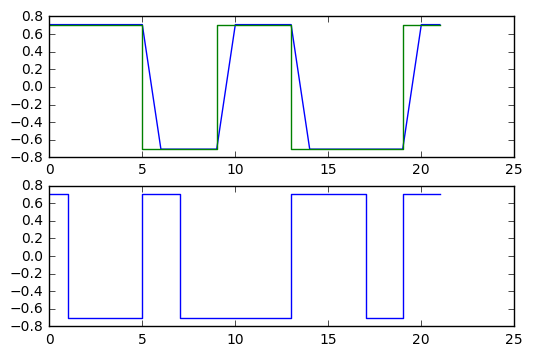

In [172]:
import matplotlib.pyplot as plt

x = [i for i in range(len(result))]
plt.subplot(211)
plt.step(x,np.real(result))

plt.subplot(212)
plt.step(x,np.imag(result))
plt.show()

This may look a little strange and I should say that we could implement similar functionality in an object oriented way.  Let's go through it.  When we call `qpsk_window()`, `state` and `idx` are initialized.  Then we declare an inner function that really performs the essence of what we want to do; packaging up pairs of bits.  

Next, we have the function that converts a pair of bits to a symbol representation.  In the case here, we are interpreting a symbol as it's complex phasor value.

```http://blog.thumbtack.net/python-coroutines```

In [2]:
def qpsk_level(state):
    symbol = 0
    if state == [1,1]:
        symbol = np.exp(1j*np.pi/4)
    elif state == [0,1]:
        symbol = np.exp(1j*3*np.pi/4)
    elif state == [1,0]:
        symbol = np.exp(1j*5*np.pi/4)
    elif state == [0,0]:
        symbol = np.exp(1j*7*np.pi/4)
    return symbol

In [3]:
def matched_filter(n):
    def inner(level):
        return np.ones(n)*level
    return inner

In [82]:
import numpy as np

result = []
def foo(x):
    result.append(5*x)
    return None 

def mapper(fun,dst=None):
    while True:
        # Wait for data
        in_data = (yield)
        
        # Apply transducer
        out_data = fun(in_data)
        
        if dst is not None:
            # Forward data on
            dst.send(out_data)
        #if out_data is not None: 
        #    dst.send(out_data)

m = mapper(foo)
next(m)
            


for a in [1,2,3,4]:
    m.send(a)
print(result)

[5, 10, 15, 20]


In [46]:
a = [1,2,3]
b = a.copy()

b[0] = 7
print(a)
print(b)

[1, 2, 3]
[7, 2, 3]


In [186]:
class QpskModulator(object):    
    constellation = {"11":np.exp(1j*1.0*np.pi/4.0),
                     "01":np.exp(1j*3.0*np.pi/4.0),
                     "00":np.exp(1j*5.0*np.pi/4.0),
                     "10":np.exp(1j*7.0*np.pi/4.0)}
    bits_per_symbol = 2
    @staticmethod
    def level(state):
        return QpskModulator.constellation[str(state[0]) + str(state[1])]   
    def __init__(self,sample_rate = 1000.0, baud_rate = 50, carrier = 100.0):
        self.sample_rate = sample_rate
        self.baud_rate = baud_rate
        self.carrier = carrier
        self.level = 1.0
    def baseband(self,bit_seq):
        samples_per_symbol = int(self.sample_rate / self.baud_rate)
        lvl = self.level 
        cnt = 0
        state = [0] * QpskModulator.bits_per_symbol
        samples = []
        phi = 0.0
        for bit in bit_seq:
            state[cnt] = bit
            cnt = (cnt + 1) % QpskModulator.bits_per_symbol          
            if cnt == 0:
                sample = QpskModulator.level(state)
                baseband = list(np.ones(samples_per_symbol) * sample)
                samples += baseband 
        return samples
    def passband(self,samples_in):
        ratio = self.carrier / self.sample_rate           
        samples_out = []
        phi = 0.0
        ratio
        for si in samples_in:
            samples_out += [si * np.exp(2.0*1j*np.pi*phi)]
            phi += ratio    
        return samples_out

In [205]:
import collections as coll 

class QpskDemodulator(object):    
    constellation = {"11":np.exp(1j*1.0*np.pi/4.0),
                     "01":np.exp(1j*3.0*np.pi/4.0),
                     "00":np.exp(1j*5.0*np.pi/4.0),
                     "10":np.exp(1j*7.0*np.pi/4.0)}
    bits_per_symbol = 2
    @staticmethod
    def level(state):
        return QpskModulator.constellation[str(state[0]) + str(state[1])]   
    def __init__(self,sample_rate = 1000.0, baud_rate = 50, carrier = 100.0):
        self.sample_rate = sample_rate
        self.baud_rate = baud_rate
        self.carrier = carrier
        self.level = 1.0
    def matched_filter(self,samples_in):
        samples_per_symbol = int(self.sample_rate / self.baud_rate)
        state = coll.deque([0.0]*samples_per_symbol)
        samples_out = []
        for si in samples_in:
            so = np.mean(state)
            _ = state.popleft()
            state.append(si)
            samples_out += [so]
        return samples_out        
    def baseband(self,samples_in):
        samples_per_symbol = int(self.sample_rate / self.baud_rate)
        state = [0.0]*samples_per_symbol
        cnt = 0
        samples_out = []
        for si in samples_in:
            state[cnt] = si
            cnt = (cnt + 1) % samples_per_symbol
            if cnt == 0:
                samples_out += [np.mean(state)] 
        return samples_out


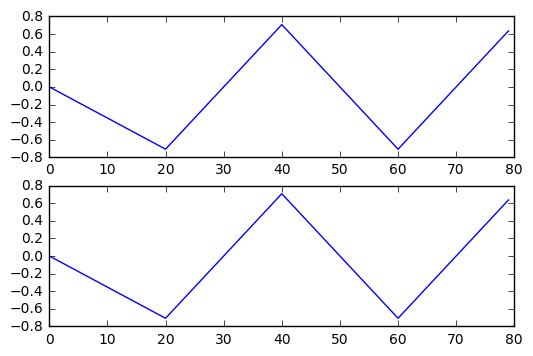

In [211]:
mod = QpskModulator()
z = mod.baseband([0,0,1,1,0,0,1,1])

demod = QpskDemodulator()
b = demod.matched_filter(z)

plt.subplot(211)
plt.plot(np.real(b))
plt.subplot(212)
plt.plot(np.imag(b))
plt.show()

In [202]:
state = coll.deque([1.0]*10)
np.mean(state)

1.0

```rust
use std::collections::VecDeque;
```

```rust
struct Symbolizer {
    bits_per_symbol:u8,
    cnt:u8,
    state: VecDeque<u8>,
}


impl Symbolizer {
    fn init_state(len:u8) -> VecDeque<u8> {
        let mut state: VecDeque<u8> = VecDeque::new();
        for i in 0..len {
            state.push_back(0);
        }
        state
    }
    
    fn new(bits_per_symbol:u8) -> Symbolizer {
        Symbolizer {
            bits_per_symbol: bits_per_symbol,
            cnt: 0,
            state: Symbolizer::init_state(bits_per_symbol)
        }
    }
    
    fn step(&mut self, bit: u8) -> Option<VecDeque<u8>> {
        self.state.push_back(bit);
        let head = self.state.pop_front();
        self.cnt = (self.cnt + 1) % self.bits_per_symbol;
        out = if (self.cnt == 0) {Some (self.state.clone()) } else {None};
        out
    }
}
```

In [28]:
foo = Symbolizer(2)
x = foo.step(1)
y = foo.step(0)
z = foo.step(0)
w = foo.step(0)
print(x)
print(y)
print(z)
print(w)

None
deque([1, 0])
None
deque([0, 0])


Before we discuss the algorithmic details of differential encoding/decoding, it's important to motivate the reason for why it might be considered.

### Motivation

### The Algorithm
At the bit-level, the algorithm is extremely simple.  Given a sequence of input bits, ${ x_{i} }$ the differentially encoded stream of bits is defined by the following recurrence relation:

\begin{equation}
    y_{i} = y_{i-1} \oplus x_{i}
\end{equation}

The differential decoder runs in the receiver and recovers the original sequence from the encoded sequence as follows:

\begin{equation}
    z_{i} = y_{i-1} \oplus y_{i}
\end{equation}

So, why does this work?  Let's prove to ourselves that differentially decoding a differentially encoded bit sequence returns
the original sequence.  For each $i$,

\begin{align}
    z_{i} &= y_{i-1} \oplus y_{i} \\
          &= y_{i-1} \oplus \left( y_{i-1} \oplus x_{i} \right) \\
          &= x_{i} \oplus \left( y_{i-1} \oplus y_{i-1} \right) \\
          &= x_{i} \oplus 0 \\
          &= x_{i}
\end{align}

Of course a real communications channel will cause some of the $y_{i}$ bits to flip.  To see the channel's impact, let

\begin{equation}
    \bar{y}_{i} = y_{i} \oplus 1.
\end{equation}

and take a look at what happens when two consecutive bit errors occur:

\begin{align}
    z_{i} &= \bar{y}_{i-1} \oplus \bar{y}_{i} \\
          &= \left( y_{i-1} \oplus 1 \right) \oplus \left( y_{i} \oplus 1 \right) \\
          &= \left( y_{i-1} \oplus y_{i} \right) \oplus \left( 1 \oplus 1 \right) \\
          &= x_{i} \oplus 0 \\
          &= x_{i}. 
\end{align}

In other words, the differential decoder fixes two consecutive bit errors.





### Design Patterns
There are a variety of ways to implement a differential encoder/decoder.  I'm really after designing my algorithms in efficient and elegant ways.  One thing I want to try to avoid is being tied to a particular type of input.  I don't want to implement separate differential encoders when the bits are coming in one at a time and when they are given to me all at once.  I want to capture the *essence* of the algorithm in a flexible and reusable module.  And if I can do this using functional programming techniques, then that's just icing on the cake.  


The first thing I need is some way to maintain state during the course of the algorithm.  Here's one option.

In [4]:
class Register(object):
    def __init__(self,val=None):
        self.val = val
    def push(self, new_value):
        self.val = new_value
    def peek(self):
        return self.val

Okay, now let's try to capture the essence of a differential encoder.  We are going to use a concept from functional programming called *currying* to do it.  All this really means is taking advantage of the mathematical fact that a function of two arguments can be interpreted as a function of one argument that returns another function of one argument.  What does currying look like in Python? Let's look at a simple example before getting to the differential encoder.  Consider a simple `adder` function that takes two numbers and adds them together:

In [22]:
def adder(x,y):
    return x + y

Here's the curried version of this function.  

In [23]:
def adder_c(x):
    def inner(y):
        return x + y
    return inner

In [16]:
def diff_enc():
    state = Register(0)
    def step(bit, signal=None):
        if signal == 1:
            state.push(0)
            return bit
        curr   = state.peek()
        output = curr ^ bit
        state.push(output)
        return output
    
    return step

In [17]:
def diff_dec():
    state = Register(0)
    def step(bit, signal=None):
        if signal == 1:
            state.push(0)
            return bit
        curr   = state.peek()
        output = curr ^ bit
        state.push(bit)
        return output
    return step

In [18]:
enc = diff_enc()
dec = diff_dec()

In [19]:
bits_in = list(map(enc,[0,1,1,0,0,1,1,0]))

In [20]:
bits_out = list(map(dec,bits_in))
bits_out

[0, 1, 1, 0, 0, 1, 1, 0]

In [21]:
foo()

NameError: name 'foo' is not defined

In [62]:
list(map(foo,[1,1,0,1,0,1,1,0,1,0,0]))

[1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]

```rust
fn diff_enc() -> Box<FnMut(i8) -> i8> {
    let mut reg: i8 = 0;
    Box :: new (move |x:i8| {
        reg ^= x;
        reg
    }
}
```

```c++
auto diff_encode = [] () {
    auto reg = std::make_shared<int>(0);
    auto step = [reg](int bit,int flip) {
        int out = *reg ^ bit;
        *reg = out ^ flip;
        return out;
    };
    return step;
};
```

```c++
enum class Bit: uint8_t { L = 0, H = 1 };
```

\begin{cases} 
      0 & x\leq 0 \\
      \frac{100-x}{100} & 0\leq x\leq 100 \\
      0 & 100\leq x 
\end{cases}


In [69]:
import pykka

ImportError: No module named 'pykka'

Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello


Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello
Hello


In [41]:
def minimize():
    current = yield
    while True:
        value = yield current
        current = min(value, current)

In [45]:
m = minimize()
next(m)

print(m.send(6))
print(m.send(32))

6
6
